In [ ]:
import pandas as pd
from pandas import qcut
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import statsmodels.api as sm

In [ ]:
df=pd.read_csv('/content/cookie_cats - cookie_cats.csv')

##Data Preparations

In [ ]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [ ]:
df['retention_1']=df['retention_1'].apply(lambda x:int(x))
df['retention_7']=df['retention_7'].apply(lambda x:int(x))

In [ ]:
df['userid'].value_counts().nunique()

1

In [ ]:
gate30=len(df[df['version']=='gate_30'])
gate30

44700

In [ ]:
gate40=len(df[df['version']=='gate_40'])
gate40

45489

##EDA

<Axes: >

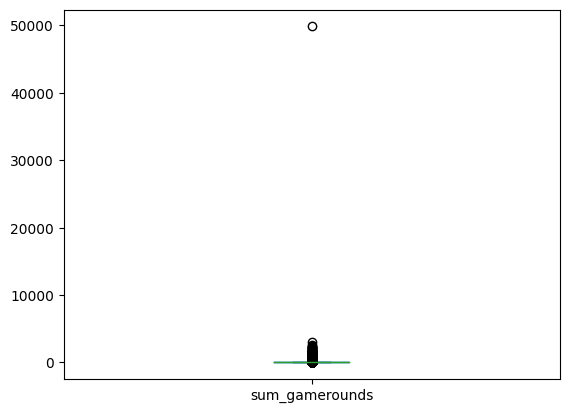

In [ ]:
df['sum_gamerounds'].plot(kind='box')

In [ ]:
#might be something wrong in the system or player cheating

In [ ]:
df[df['sum_gamerounds']==49854]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,0,1


In [ ]:
df=df.drop(df[df['sum_gamerounds']==49854].index)

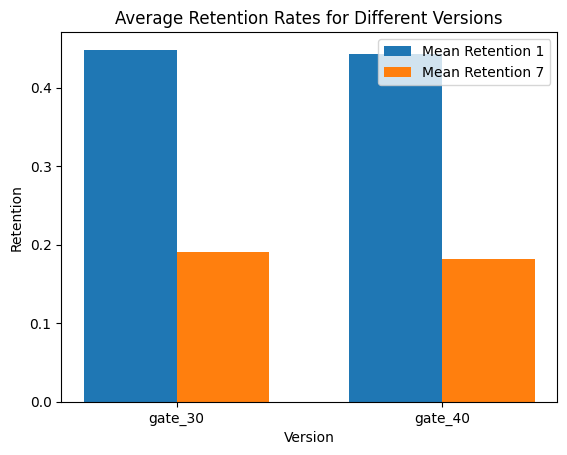

In [ ]:
dfn = df.groupby('version').mean()
bar_width = 0.35
x = range(len(dfn.index))
fig, ax = plt.subplots()
bars1 = ax.bar(x, dfn['retention_1'], width=bar_width, label='Mean Retention 1')
bars2 = ax.bar([p + bar_width for p in x], dfn['retention_7'], width=bar_width, label='Mean Retention 7')
ax.set_xlabel('Version')
ax.set_ylabel('Retention')
ax.set_title('Average Retention Rates for Different Versions')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(dfn.index)
ax.legend()
plt.show()

Text(0.5, 1.0, 'Different Versions and First Minute Retention Rate')

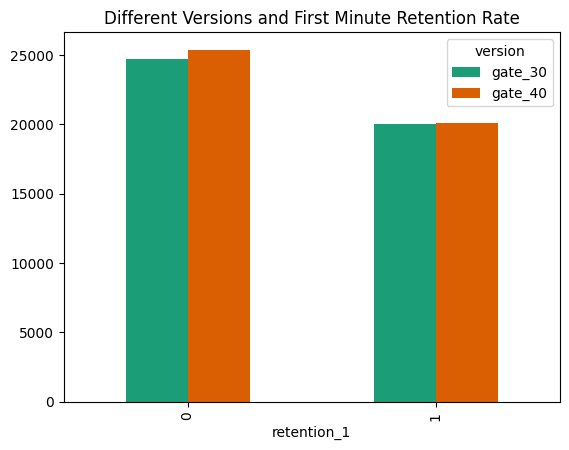

In [ ]:
dfn = df.groupby(['retention_1','version']).count().unstack('version')
dfn['userid'].plot(kind='bar',color=sns.palettes.mpl_palette('Dark2'))
plt.title('Different Versions and First Minute Retention Rate')

Text(0.5, 1.0, 'Different Versions and Seventh Minute Retention Rate')

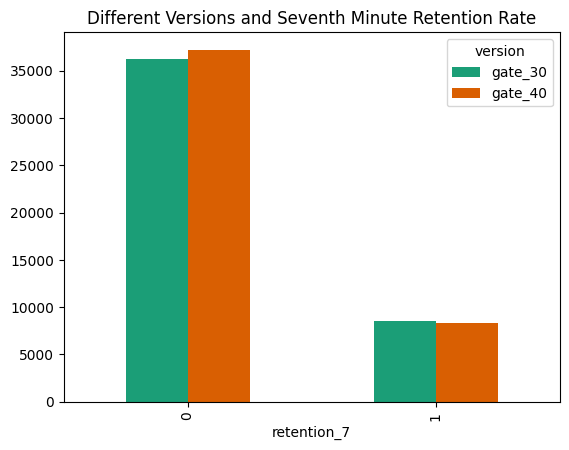

In [ ]:
dfn = df.groupby(['retention_7','version']).count().unstack('version')
dfn['userid'].plot(kind='bar',color=sns.palettes.mpl_palette('Dark2'))
plt.title('Different Versions and Seventh Minute Retention Rate')

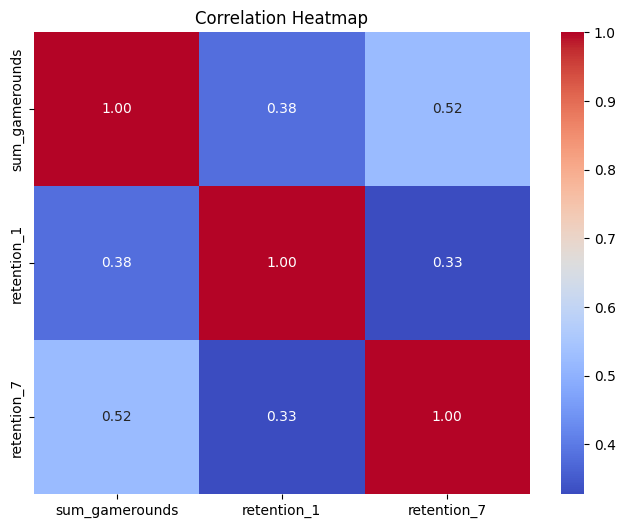

In [ ]:
corr = df[['sum_gamerounds', 'retention_1', 'retention_7']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

##Basic Analysis

In [ ]:
df[['retention_1','retention_7','sum_gamerounds']].groupby(df['version']).agg({'retention_1':'mean','retention_7':'mean','sum_gamerounds':'mean'})

,retention_1,retention_7,sum_gamerounds
version,,,
gate_30,0.448198,0.190183,51.342111
gate_40,0.442283,0.182000,51.298776


##Conversion

In [ ]:
group30 = df[df['version'] == 'gate30']
group40 = df[df['version'] == 'gate40']

In [ ]:
import statsmodels.api as sm
from scipy.stats import norm

In [ ]:
def proportion_z_test(group1, group2, event_column):
    x1 = group1[event_column].sum()
    n1 = group1[event_column].count()
    x2 = group2[event_column].sum()
    n2 = group2[event_column].count()
    z_score, p_value = sm.stats.proportions_ztest([x1, x2], [n1, n2])
    return z_score, p_value
group30 = df[df['version'] == 'gate_30']
group40 = df[df['version'] == 'gate_40']

z_score_1, p_value_1 = proportion_z_test(group30, group40, 'retention_1')
z_score_7, p_value_7 = proportion_z_test(group30, group40, 'retention_7')

In [ ]:
z_score_1, p_value_1

(1.787103509763628, 0.0739207603418346)

In [ ]:
z_score_7, p_value_7

(3.1574100858819936, 0.0015917731773993442)

A positive Z-score in the context of gate_30 vs. gate_40 implies that the retention rate for gate_30 is higher than that for gate_40

For Day 7 retention, the Z-score was significantly positive and the P-value was less than 0.05. This indicates that the retention rate for gate_30 was statistically significantly higher than for gate_40 with high confidence.

Since the Z-score is positive, the effect's direction is in favor of gate_30, meaning gate_30 had a higher retention rate compared to gate_40 on Day 7.

In [ ]:
def bootstrap_ab_test(data1, data2, n_bootstrap=1000):
    bootstrap_diffs = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, replace=True, size=len(data1))
        sample2 = np.random.choice(data2, replace=True, size=len(data2))
        bootstrap_diffs.append(np.mean(sample1) - np.mean(sample2))
    #original_diff = np.mean(data1) - np.mean(data2)
    probability = np.mean([diff >= 0 for diff in bootstrap_diffs])
    return probability
p_val_bootstrap_1 = bootstrap_ab_test(group30['retention_1'], group40['retention_1'])
p_val_bootstrap_7 = bootstrap_ab_test(group30['retention_7'], group40['retention_7'])

Compare with 0

In [ ]:
p_val_bootstrap_1

0.958

In [ ]:
p_val_bootstrap_7

0.997

differences between two groups are very small

In [ ]:
def proportions_z_test(success_a, n_a, success_b, n_b):
    p1 = success_a / n_a
    p2 = success_b / n_b
    p_pool = (success_a + success_b) / (n_a + n_b)
    z_stat = (p1 - p2) / np.sqrt(p_pool * (1 - p_pool) * (1 / n_a + 1 / n_b))
    p_value = 1 - norm.cdf(np.abs(z_stat))  # one-tail test
    return z_stat, p_value

# Calculate the sums and counts for the z-test
x1_day1, n1_day1 = group30['retention_1'].sum(), group30['retention_1'].count()
x2_day1, n2_day1 = group40['retention_1'].sum(), group40['retention_1'].count()
x1_day7, n1_day7 = group30['retention_7'].sum(), group30['retention_7'].count()
x2_day7, n2_day7 = group40['retention_7'].sum(), group40['retention_7'].count()

# Perform the z-test for Day 1 and Day 7 retention
z_score_1, p_value_1 = proportions_z_test(x1_day1, n1_day1, x2_day1, n2_day1)
z_score_7, p_value_7 = proportions_z_test(x1_day7, n1_day7, x2_day7, n2_day7)

In [ ]:
z_score_1, p_value_1

(1.787103509763628, 0.036960380170917295)

In [ ]:
z_score_7, p_value_7

(3.1574100858819936, 0.000795886588699668)

Day 1 Retention: There is no significant difference between the gate 30 and gate 40 versions in terms of player retention on the first day after installation.

Day 7 Retention: The statistical package shows a significant difference in retention after 7 days, favoring the gate 30 version. However, the Bootstrap method does not show a significant difference, suggesting the need for cautious interpretation, perhaps due to the variability in the data or the model used.

The results indicate that gate_30 might be better in terms of improving player retention after 7 days, based on the z-test, but the bootstrap method advises a cautious interpretation. This can be an indication to perform further tests or consider other factors in decision making. ​